### Imports

In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing related libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn.functional as F

### Configuration

In [2]:
# Set Parameters
class Config:
    def __init__(self):
        self.image_dir = os.path.join(os.getcwd(), "images")
        self.train_path = os.path.join(os.getcwd(), "train.csv")
        self.test_path = os.path.join(os.getcwd(), "test.csv")
        self.validation_path = os.path.join(os.getcwd(), "val.csv")
        self.image_size = (224, 224)
        self.batch_size = 32
        self.num_epochs = 50
        self.learning_rate = 0.001
        self.latent_dim = 48
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_classes = 2
        self.is_local_test = True
        self.sample_size = 1000
        self.k_fold = 5
        self.seed = 42

config = Config()


### Create Custom Dataset

In [3]:
# Define Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, image_paths, transforms=None):
        self.image_paths = image_paths
        self.transforms = transforms
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        img_path = self.image_paths[index]
        image = Image.open(img_path).convert("RGB")
        # Transform
        if self.transforms:
            image = self.transforms(image)
        return image

### Create Autoencoder using CNN

In [4]:
# Define Autoencoder using CNN
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim

        # Define Encoder
        self.cnn_encoder = nn.Sequential(
            # Layer 1
            # 224x224x3 -> 224x224x32
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 224x224x32 -> 112x112x32
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Layer 2
            # 112x112x32 -> 112x112x64
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 112x112x64 -> 56x56x64
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Layer 3
            # 56x56x64 -> 56x56x128
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 56x56x128 -> 28x28x128
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Layer 4
            # 28x28x128 -> 28x28x256
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # 28x28x256 -> 14x14x256
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            # 14x14x256 -> [self.latent_dim]
            nn.Linear(14 * 14 * 256, self.latent_dim),
            nn.ReLU()
        )


        # Define Decoder
        self.cnn_decoder = nn.Sequential(
            # [self.latent_dim] -> 14x14x256
            nn.Linear(self.latent_dim, 14 * 14 * 256),
            nn.ReLU(),
            nn.Unflatten(1, (256, 14, 14)),

            # Layer 1
            # 14x14x256 -> 28x28x256
            nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            # Layer 2
            # 28x28x256 -> 56x56x128
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Layer 3
            # 56x56x128 -> 112x112x64
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # Layer 4
            # 112x112x64 -> 224x224x32
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            # Layer 5
            # 224x224x32 -> 224x224x3
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, X):
        latent = self.cnn_encoder(X)
        reconstructed = self.cnn_decoder(latent)
        return latent, reconstructed

### Load Data

In [5]:
# Load Data
train = pd.read_csv(config.train_path)
test = pd.read_csv(config.test_path)
val = pd.read_csv(config.validation_path)

# If testing locally, sample the dataset
if config.is_local_test:
    train = train.sample(n=config.sample_size, random_state=42).reset_index(drop=True)
    test = test.sample(n=config.sample_size, random_state=42).reset_index(drop=True)
    val = val.sample(n=config.sample_size, random_state=42).reset_index(drop=True)

train_image_paths = [os.path.join(config.image_dir, f"{id}.jpg") for id in train["ID"]]
test_image_paths = [os.path.join(config.image_dir, f"{id}.jpg") for id in test["ID"]]
val_image_paths = [os.path.join(config.image_dir, f"{id}.jpg") for id in val["ID"]]


print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of test images: {len(test_image_paths)}")
print(f"Number of validation images: {len(val_image_paths)}")

Number of training images: 1000
Number of test images: 1000
Number of validation images: 1000


### Calculate mean and std base on images

In [6]:
calculation_transform = transforms.Compose([
    transforms.Resize(config.image_size),
    transforms.ToTensor()
])

calculation_dataset = CustomDataset(train_image_paths, transforms=calculation_transform)
calculation_loader = DataLoader(calculation_dataset, batch_size=config.batch_size, shuffle=False)

pixels_sum = torch.tensor([0.0, 0.0, 0.0])
pixels_sum_sq = torch.tensor([0.0, 0.0, 0.0])
count = 0

for inputs in calculation_loader:
    inputs = inputs.to(config.device)
    # Shape: [batch_size, 3, 224, 224]
    # Sum all the pixels values per channel across batch, height, and width
    pixels_sum  += inputs.sum(dim=[0, 2, 3])
    
    # Sum of squares
    pixels_sum_sq += (inputs ** 2).sum(dim=[0, 2, 3])
    
    # Total number of pixels = batch_size * height * width
    count += inputs.size(0) * config.image_size[0] * config.image_size[1]

# var(x) = E[x^2] - (E[x])^2
# mean(x) = E[x]
total_mean = pixels_sum / count
total_std = torch.sqrt(pixels_sum_sq / count - total_mean ** 2)

In [7]:
print(f"Mean: {total_mean}")
print(f"Std: {total_std}")

Mean: tensor([0.5230, 0.4213, 0.3374])
Std: tensor([0.2846, 0.2766, 0.2774])


### Build Image Transform Pipeline

In [8]:
# Define Image Transformations
transform = transforms.Compose([
    transforms.Resize(config.image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=total_mean.tolist(), std=total_std.tolist())
])

In [9]:
# Train Loader
autoencoder_train_dataset = CustomDataset(train_image_paths, transforms=transform)
autoencoder_train_loader = DataLoader(autoencoder_train_dataset, batch_size=config.batch_size, shuffle=True)

# Test Loader
autoencoder_test_dataset = CustomDataset(train_image_paths, transforms=transform)
autoencoder_test_loader = DataLoader(autoencoder_test_dataset, batch_size=config.batch_size, shuffle=False)

# Validation Loader
autoencoder_val_dataset = CustomDataset(train_image_paths, transforms=transform)
autoencoder_val_loader = DataLoader(autoencoder_val_dataset, batch_size=config.batch_size, shuffle=False)

### Train, test and validate Autoencoder

Using MPS device: mps
Epoch [1/50], Train Loss: 1.0954, Validation Loss: 1.0369, Time: 136.75s
Epoch [2/50], Train Loss: 0.8360, Validation Loss: 0.8128, Time: 160.32s
Epoch [3/50], Train Loss: 0.7458, Validation Loss: 0.6915, Time: 184.33s
Epoch [4/50], Train Loss: 0.6682, Validation Loss: 0.6405, Time: 215.84s
Epoch [5/50], Train Loss: 0.6260, Validation Loss: 0.7095, Time: 259.06s
Epoch [6/50], Train Loss: 0.5970, Validation Loss: 0.5871, Time: 292.80s
Epoch [7/50], Train Loss: 0.5661, Validation Loss: 0.5641, Time: 323.21s
Epoch [8/50], Train Loss: 0.5587, Validation Loss: 0.5319, Time: 355.13s
Epoch [9/50], Train Loss: 0.5299, Validation Loss: 0.5270, Time: 385.35s
Epoch [10/50], Train Loss: 0.5233, Validation Loss: 0.5214, Time: 418.34s
Epoch [11/50], Train Loss: 0.5271, Validation Loss: 0.5769, Time: 470.04s
Epoch [12/50], Train Loss: 0.5097, Validation Loss: 0.4959, Time: 508.47s
Epoch [13/50], Train Loss: 0.5026, Validation Loss: 0.5134, Time: 547.31s
Epoch [14/50], Train Loss

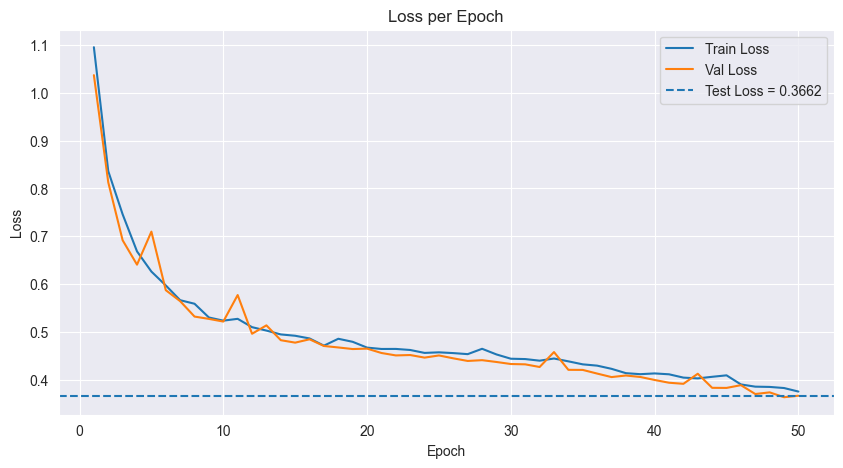

In [10]:
import time

# 1. Initialize Model, Loss Function, and Optimizer
device = config.device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using MPS device: {device}")

elif torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")

else:
    device = torch.device("cpu")
    print(f"Using CPU: {device}")

auto_model = Autoencoder(latent_dim=config.latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(auto_model.parameters(), lr=config.learning_rate)

# 2. Training Loop
def train_model(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for batch in data_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        # Forward pass
        _, reconstructed = model(batch) 
        # Compute loss
        loss = criterion(reconstructed, batch)   
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(data_loader)


# 3. Validation Loop
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            _, reconstructed = model(batch)
            loss = criterion(reconstructed, batch)
            running_loss += loss.item()
    return running_loss / len(data_loader)
            
# 4. Train and validate
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    start_time = time.time()

    for epoch in range(num_epochs):
        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        val_loss = evaluate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Validation Loss: {val_loss:.4f}, "
              f"Time: {time.time() - start_time:.2f}s")
        
    elapsed_time = time.time() - start_time
    print(f"Training completed in {elapsed_time:.2f} seconds")
    return train_losses, val_losses

# 5. Run
train_losses, val_losses = train_and_validate(
    auto_model,
    autoencoder_train_loader,
    autoencoder_val_loader,
    criterion,
    optimizer,
    config.num_epochs,
    device
)

# 6. Test the model
test_loss = evaluate_model(auto_model, autoencoder_test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")

# 7. Plotting
epochs = range(1, config.num_epochs + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.axhline(test_loss, linestyle="--", label=f"Test Loss = {test_loss:.4f}")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


/var/folders/66/1q8bft0j43j9_rs20_lp5zj80000gn/T/ipykernel_36492/3624742875.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(total_mean).view(3, 1, 1)
/var/folders/66/1q8bft0j43j9_rs20_lp5zj80000gn/T/ipykernel_36492/3624742875.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(total_std).view(3, 1, 1)


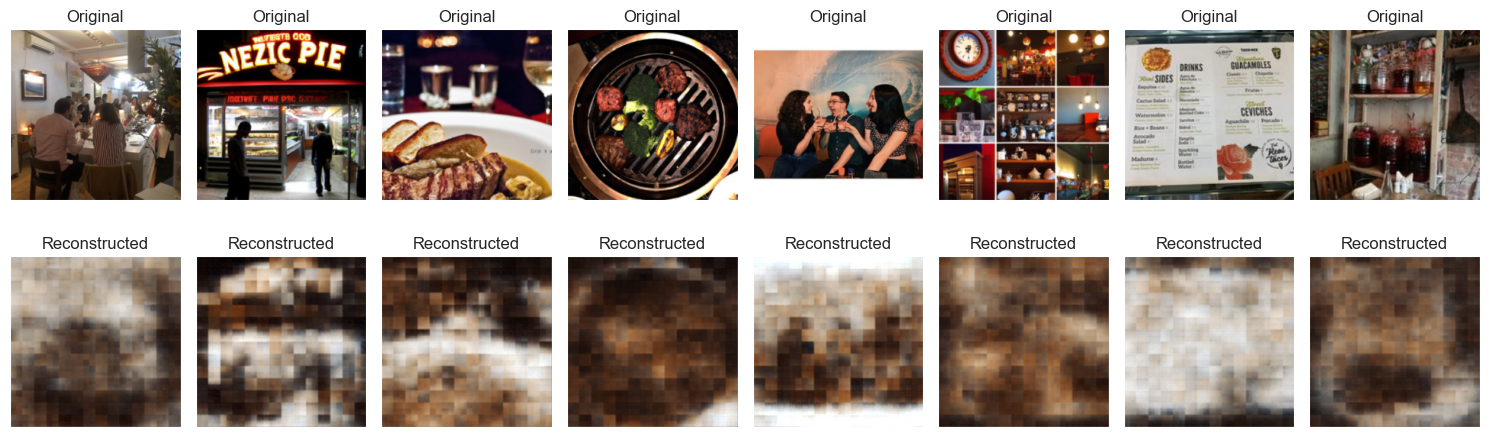

In [11]:
def imshow(img_tensor, title=None):
    # Clone tensor, move to CPU
    img = img_tensor.cpu().clone().detach()
    # Reshape for broadcasting
    mean = torch.tensor(total_mean).view(3, 1, 1) 
    std = torch.tensor(total_std).view(3, 1, 1)
    img = img * std + mean
    # Clip values to [0, 1] range after unnormalizing
    img = torch.clip(img, 0, 1)
    # Convert tensor to numpy array and transpose dimensions for display
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)

# Get a batch of images from the training loader
dataiter = iter(autoencoder_train_loader)
images = next(dataiter)
images_subset = images[:8].to(device)

# Get reconstructions
auto_model.eval()
with torch.no_grad():
    latent_vectors, reconstructed_images = auto_model(images_subset)

reconstructed_images = reconstructed_images.cpu()
images_subset_cpu = images_subset.cpu()

# Plot the originals and reconstructions
plt.figure(figsize=(15, 5))
for i in range(len(images_subset_cpu)):
    # Display original
    ax = plt.subplot(2, len(images_subset_cpu), i + 1)
    imshow(images_subset_cpu[i], title="Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, len(images_subset_cpu), i + 1 + len(images_subset_cpu))
    imshow(reconstructed_images[i], title="Reconstructed")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

### Save the Autoencoder

In [12]:
torch.save(auto_model.state_dict(), os.path.join(os.getcwd(), "autoencoder_model.pth"))

### Concatenation with Textual Features

In [13]:
# Set the model to evaluation mode
auto_model.eval()

feature_dataset_train = CustomDataset(train_image_paths, transforms=transform)
feature_loader_train = DataLoader(feature_dataset_train, batch_size=config.batch_size, shuffle=False)


# Get the latent vectors
latent_vectors = []
with torch.no_grad():
    for batch in feature_loader_train:
        # Move batch to device
        batch = batch.to(device)
        latent = auto_model.cnn_encoder(batch)
        # Move back to CPU and convert to numpy and append to list
        # Shape: [batch_size, latent_dim]
        latent_vectors.append(latent.cpu().numpy())

# Concatenate all latent vectors to [1000, latent_dim]
latent_vectors = np.concatenate(latent_vectors, axis=0)
# Check the shape, it should be [1000, 48]
print(f"Shape of latent vectors: {latent_vectors.shape}")


Shape of latent vectors: (1000, 48)


In [14]:
latent_vectors[0]

array([ 69.26229  ,   0.       ,  69.24382  ,   0.       ,  38.392616 ,
       103.07787  ,  44.927834 ,  61.701862 , 174.43607  ,  67.99519  ,
        87.21791  , 116.41808  ,   0.       ,  81.80373  , 107.66994  ,
         0.       , 102.54201  ,   0.       ,   0.       ,  55.65161  ,
         0.       ,   0.       , 103.87921  ,  44.442627 ,  19.732473 ,
         0.       ,  76.2831   ,  49.998867 ,   0.       ,   0.       ,
         0.       ,  68.127884 ,  57.58343  , 122.701935 , 119.511284 ,
        80.161156 ,  61.18559  ,  41.749107 ,  26.096485 ,   1.9042029,
         0.       ,   0.       ,   0.       ,  75.511345 ,   0.       ,
         0.       , 103.14538  ,   0.       ], dtype=float32)

### Concatenate textual data with image pixels

#### Check NaN values

In [15]:
view = train.copy()
view.isnull().sum()

ID                             0
text                           0
label                          0
automated_readability_index    0
difficult_words                0
flesch_reading_ease            0
gunning_fog                    0
words_per_sentence             0
reading_time                   0
ppl                            0
bright                         0
cont                           0
warm                           0
colorf                         0
sd                             2
cd                             2
td                             2
diag_dom                       1
rot                            1
hpvb                           0
vpvb                           0
hcvb                           0
vcvb                           0
sat                            0
clar                           0
dtype: int64

#### Use median to Impute training features

In [16]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
impute_cols = ["sd","cd","td","diag_dom","rot"]
               
train[impute_cols] = imputer.fit_transform(train[impute_cols])
train.isnull().sum()

ID                             0
text                           0
label                          0
automated_readability_index    0
difficult_words                0
flesch_reading_ease            0
gunning_fog                    0
words_per_sentence             0
reading_time                   0
ppl                            0
bright                         0
cont                           0
warm                           0
colorf                         0
sd                             0
cd                             0
td                             0
diag_dom                       0
rot                            0
hpvb                           0
vpvb                           0
hcvb                           0
vcvb                           0
sat                            0
clar                           0
dtype: int64

In [17]:
text_train_data = train.copy()
text_train_data.drop(columns=["ID", "text"], inplace=True)

# Convert into numpy array
X_train = text_train_data.iloc[:, 1:].values
y_train = text_train_data.loc[:, "label"].values

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of X_train: (1000, 22)
Shape of y_train: (1000,)


In [18]:
X_train = np.concatenate((X_train, latent_vectors), axis=1)
print(f"Shape of X_train after concatenation: {X_train.shape}") # 22 + 48 = 70

Shape of X_train after concatenation: (1000, 70)


### Decision Tree + Adaboosting
* 2 levels of tree and 5 nodes
* psuedo code reference: https://en.wikipedia.org/wiki/AdaBoost


In [ ]:
def ada_boost(N, X_train, y_train, X_test, y_test):
    from sklearn.tree import DecisionTreeClassifier
    # Convert labels: 0 to -1 and 1 to 1
    y_train_new = np.where(y_train == 0, -1, 1)
    y_test_new = np.where(y_test == 0, -1, 1)

    # Get the number of samples
    n_samples = X_train.shape[0]

    # Initialize weights
    weights = np.ones(n_samples) / n_samples

    # Initialize base classifier
    learners = []
    alphas = []
    
    for t in range(N):
        # Weak learner using Decision Tree
        learner = DecisionTreeClassifier(
            max_depth=2,
            max_leaf_nodes=5,
            random_state=config.seed
        )

        learner.fit(X_train, y_train, sample_weight=weights)

        # Compute weighted error
        y_pred = learner.predict(X_train)
        numerator = np.dot(weights, (y_pred != y_train))
        denominator = np.sum(weights)
        error = numerator / denominator

        # Compute alpha
        # Add a small value to avoid division error
        alpha = 0.5 * np.log((1 - error) / (error + 1e-9))

        # Append the learner and alpha 
        learners.append(learner)
        alphas.append(alpha)

        # Update weights
        y_pred_new = np.where(y_pred == 0, -1, 1)
        weights *= np.exp(-alpha * y_train_new * y_pred_new)
        weights /= np.sum(weights)

    # Define predict function
    def predict(X):
        result = np.zeros(X.shape[0])
        for alpha, learner in zip(alphas, learners):
            pred = learner.predict(X)
            pred_new = np.where(pred == 0, -1, 1)
            result += alpha * pred_new
        return (result >= 0).astype(int)
    
    # Predict on train and test data
    y_train_pred = predict(X_train)
    y_test_pred = predict(X_test)

    acc_train = np.mean(y_train_pred == y_train)
    err_train = 1 - acc_train

    acc_test = np.mean(y_test_pred == y_test)
    err_test = 1 - acc_test

    return (learners, alphas, acc_train, err_train, acc_test, err_test, y_train_pred, y_test_pred)
        

### K-fold Cross Validation
* We have to do both Stratified and Non-stratified

In [20]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [21]:
def run_cross_validation(X, y, model, n_rounds):
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    errors = []

    for train_index, test_index in model.split(X, y):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]

        # Call ada boosting
        learners, alphas, acc_train, err_train, acc_test, err_test, y_train_pred, y_test_pred = ada_boost(
            N=n_rounds,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test
        )

        accuracies.append(accuracy_score(y_test, y_test_pred))
        errors.append(err_test)
        precisions.append(precision_score(y_test, y_test_pred))
        recalls.append(recall_score(y_test, y_test_pred))
        f1s.append(f1_score(y_test, y_test_pred))

    return {
        "accuracy": (np.mean(accuracies), np.std(accuracies)),
        "error": (np.mean(errors), np.std(errors)),
        "precision": np.mean(precisions),
        "recall": np.mean(recalls),
        "f1": np.mean(f1s)
    }


In [22]:
BOOSTING_ROUNDS = 50

In [ ]:
# Normal k-fold cross-validation with k=5
kf = KFold(n_splits=config.k_fold, shuffle=True, random_state=config.seed)

# Stratified k-fold cross-validation with k=5
skf = StratifiedKFold(n_splits=config.k_fold, shuffle=True, random_state=config.seed)

kf_result = run_cross_validation(X_train, y_train, kf, BOOSTING_ROUNDS)

print("Decision Tree/Adaboost with K-Fold Cross Validation Results:")
print(f'Accuracy: Mean={kf_result["accuracy"][0]:.4f}, std={kf_result["accuracy"][1]:.4f}')
print(f'Error: Mean={kf_result["error"][0]:.4f}, std={kf_result["error"][1]:.4f}')
print(f'Precision: {kf_result["precision"]:.4f}')
print(f'Recall: {kf_result["recall"]:.4f}')
print(f'F1 Score: {kf_result["f1"]:.4f}')

print("=" * 50)

skf_result = run_cross_validation(X_train, y_train, skf, BOOSTING_ROUNDS)
print("Decision Tree/Adaboost with Stratified K-Fold Cross Validation Results:")
print(f'Accuracy: Mean={skf_result["accuracy"][0]:.4f}, std={skf_result["accuracy"][1]:.4f}')
print(f'Error: Mean={skf_result["error"][0]:.4f}, std={skf_result["error"][1]:.4f}')
print(f'Precision: {skf_result["precision"]:.4f}')
print(f'Recall: {skf_result["recall"]:.4f}')
print(f'F1 Score: {skf_result["f1"]:.4f}')

Decision Tree/Adaboost with K-Fold Cross Validation Results:
Accuracy: Mean=0.9880, std=0.0051
Error: Mean=0.5160, std=0.0227
Precision: 0.9879
Recall: 0.9880
F1 Score: 0.9879
Decision Tree/Adaboost with Stratified K-Fold Cross Validation Results:
Accuracy: Mean=0.9810, std=0.0037
Error: Mean=0.5200, std=0.0000
Precision: 0.9817
Recall: 0.9796
F1 Score: 0.9806


### Random Forest and K-Fold Cross Validation

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1"
}

# Random Forest Classifier with K-Fold Cross Validation
rf = RandomForestClassifier(n_estimators=50, random_state=config.seed)
rf_kfold_result = cross_validate(rf, X_train, y_train, cv=kf, scoring=scoring, return_train_score=False)

print("Random Forest Classifier with K-Fold Cross Validation Results:")
print(f"Accuracy: {np.mean(rf_kfold_result['test_accuracy']):.4f}")
print(f"Precision: {np.mean(rf_kfold_result['test_precision']):.4f}")
print(f"Recall: {np.mean(rf_kfold_result['test_recall']):.4f}")
print(f"F1 Score: {np.mean(rf_kfold_result['test_f1']):.4f}")


print("=" * 50)

# Random Forest Classifier with Stratified K-Fold Cross Validation
rf_skfold_result = cross_validate(rf, X_train, y_train, cv=skf, scoring=scoring, return_train_score=False)
print("Random Forest Classifier with Stratified K-Fold Cross Validation Results:")
print(f"Accuracy: {np.mean(rf_skfold_result['test_accuracy']):.4f}")
print(f"Precision: {np.mean(rf_skfold_result['test_precision']):.4f}")
print(f"Recall: {np.mean(rf_skfold_result['test_recall']):.4f}")
print(f"F1 Score: {np.mean(rf_skfold_result['test_f1']):.4f}")

Random Forest Classifier with K-Fold Cross Validation Results:
Accuracy: 0.9710
Precision: 0.9756
Recall: 0.9650
F1 Score: 0.9702
Random Forest Classifier with Stratified K-Fold Cross Validation Results:
Accuracy: 0.9740
Precision: 0.9795
Recall: 0.9673
F1 Score: 0.9733


### SVM

In [25]:
# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

In [26]:
from sklearn.svm import SVC

svm = SVC(kernel="rbf", random_state=config.seed)

svm_kfold_result = cross_validate(svm, X_train_scaled, y_train, cv=kf, scoring=scoring, return_train_score=False)
print("SVM with K-Fold Cross Validation Results:")
print(f"Accuracy: {np.mean(svm_kfold_result['test_accuracy']):.4f}")
print(f"Precision: {np.mean(svm_kfold_result['test_precision']):.4f}")
print(f"Recall: {np.mean(svm_kfold_result['test_recall']):.4f}")
print(f"F1 Score: {np.mean(svm_kfold_result['test_f1']):.4f}")

print("=" * 50)

svm_skfold_result = cross_validate(svm, X_train_scaled, y_train, cv=skf, scoring=scoring, return_train_score=False)
print("SVM with Stratified K-Fold Cross Validation Results:")
print(f"Accuracy: {np.mean(svm_skfold_result['test_accuracy']):.4f}")
print(f"Precision: {np.mean(svm_skfold_result['test_precision']):.4f}")
print(f"Recall: {np.mean(svm_skfold_result['test_recall']):.4f}")
print(f"F1 Score: {np.mean(svm_skfold_result['test_f1']):.4f}")

SVM with K-Fold Cross Validation Results:
Accuracy: 0.9630
Precision: 0.9544
Recall: 0.9714
F1 Score: 0.9626
SVM with Stratified K-Fold Cross Validation Results:
Accuracy: 0.9600
Precision: 0.9488
Recall: 0.9714
F1 Score: 0.9598


### Plotting Comparison

In [27]:
comparison_df = pd.DataFrame(columns=["Model", "CV Type", "Accuracy", "Precision", "Recall", "F1 Score"])

comparison_df = pd.concat([comparison_df, pd.DataFrame({
    "Model": ["Decision Tree/Adaboost"] * 2,
    "CV Type": ["K-Fold", "Stratified K-Fold"],
    "Accuracy": [kf_result["accuracy"][0], skf_result["accuracy"][0]],
    "Precision": [kf_result["precision"], skf_result["precision"]],
    "Recall": [kf_result["recall"], skf_result["recall"]],
    "F1 Score": [kf_result["f1"], skf_result["f1"]]
})])
comparison_df = pd.concat([comparison_df, pd.DataFrame({
    "Model": ["Random Forest"] * 2,
    "CV Type": ["K-Fold", "Stratified K-Fold"],
    "Accuracy": [np.mean(rf_kfold_result["test_accuracy"]), np.mean(rf_skfold_result["test_accuracy"])],
    "Precision": [np.mean(rf_kfold_result["test_precision"]), np.mean(rf_skfold_result["test_precision"])],
    "Recall": [np.mean(rf_kfold_result["test_recall"]), np.mean(rf_skfold_result["test_recall"])],
    "F1 Score": [np.mean(rf_kfold_result["test_f1"]), np.mean(rf_skfold_result["test_f1"])]
})])
comparison_df = pd.concat([comparison_df, pd.DataFrame({
    "Model": ["SVM"] * 2,
    "CV Type": ["K-Fold", "Stratified K-Fold"],
    "Accuracy": [np.mean(svm_kfold_result["test_accuracy"]), np.mean(svm_skfold_result["test_accuracy"])],
    "Precision": [np.mean(svm_kfold_result["test_precision"]), np.mean(svm_skfold_result["test_precision"])],
    "Recall": [np.mean(svm_kfold_result["test_recall"]), np.mean(svm_skfold_result["test_recall"])],
    "F1 Score": [np.mean(svm_kfold_result["test_f1"]), np.mean(svm_skfold_result["test_f1"])]
})])
comparison_df = comparison_df.reset_index(drop=True)

/var/folders/66/1q8bft0j43j9_rs20_lp5zj80000gn/T/ipykernel_36492/3153158437.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  comparison_df = pd.concat([comparison_df, pd.DataFrame({


In [28]:
comparison_df


,Model,CV Type,Accuracy,Precision,Recall,F1 Score
0,Decision Tree/Adaboost,K-Fold,0.988,0.987866,0.987966,0.987906
1,Decision Tree/Adaboost,Stratified K-Fold,0.981,0.981652,0.979592,0.980607
2,Random Forest,K-Fold,0.971,0.975634,0.965014,0.970211
3,Random Forest,Stratified K-Fold,0.974,0.979504,0.967347,0.973310
4,SVM,K-Fold,0.963,0.954379,0.971433,0.962605
5,SVM,Stratified K-Fold,0.960,0.948836,0.971429,0.959823


In [29]:
# Convert to long form for seaborn
comparison_df_long = pd.melt(comparison_df, id_vars=["Model", "CV Type"], 
                              value_vars=["Accuracy", "Precision", "Recall", "F1 Score"],
                              var_name="Metric", value_name="Score")
comparison_df_long

,Model,CV Type,Metric,Score
0,Decision Tree/Adaboost,K-Fold,Accuracy,0.988000
1,Decision Tree/Adaboost,Stratified K-Fold,Accuracy,0.981000
2,Random Forest,K-Fold,Accuracy,0.971000
3,Random Forest,Stratified K-Fold,Accuracy,0.974000
4,SVM,K-Fold,Accuracy,0.963000
5,SVM,Stratified K-Fold,Accuracy,0.960000
6,Decision Tree/Adaboost,K-Fold,Precision,0.987866
7,Decision Tree/Adaboost,Stratified K-Fold,Precision,0.981652
8,Random Forest,K-Fold,Precision,0.975634
9,Random Forest,Stratified K-Fold,Precision,0.979504


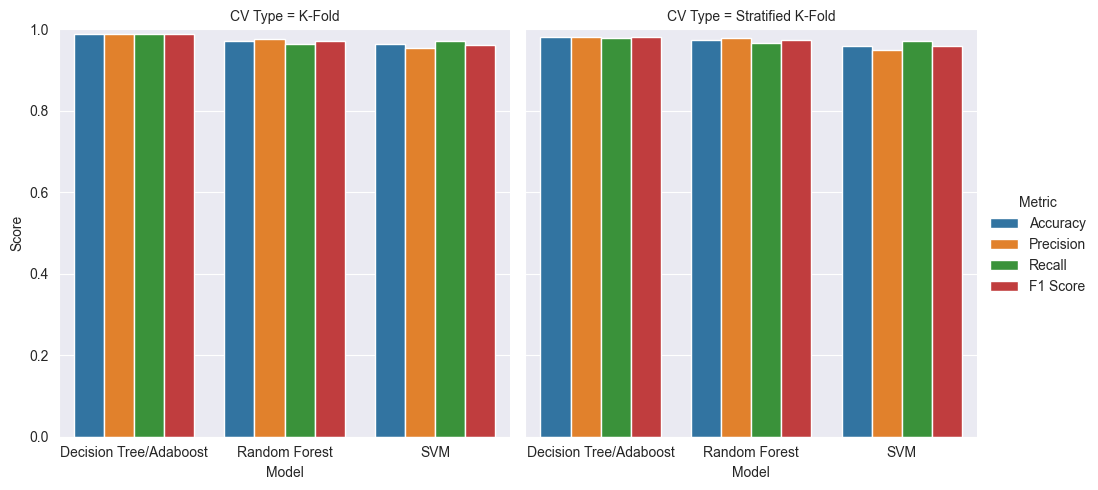

In [30]:
sns.catplot(data=comparison_df_long, x="Model", y="Score", hue="Metric", col="CV Type", kind="bar")
plt.ylim(0, 1)
plt.show()

### Comparative Analysis and Interpretation

#### Examine Label Distribution After Random Choice of Data

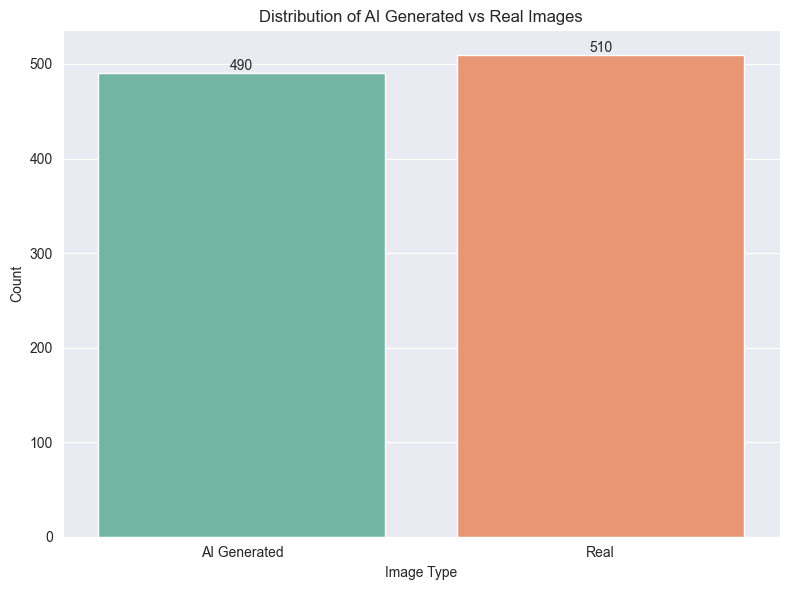

In [31]:
ai_gen_count = train.query("label == 1").shape[0]
real_count = train.query("label == 0").shape[0]
df_counts = pd.DataFrame({
    "Image Type": ["AI Generated", "Real"],
    "Count": [ai_gen_count, real_count]
})
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_counts, x="Image Type", y="Count", palette="Set2", hue=["AI Generated", "Real"])
for i in ax.containers:
    ax.bar_label(i, )

plt.title("Distribution of AI Generated vs Real Images")
plt.ylabel("Count")
plt.xlabel("Image Type")
plt.tight_layout()
plt.show()

#### Most Suitable Metric: F-1 Score
Since F-1 Score can balance between precision and recall, which is important when considering both false positives and false negatives, I will choose it as the most suitable metric.
#### Stratified 5-fold vs. Unstratified 5-fold:
Overall observations: Since the dataset are almost balanced (490 vs. 510), the metrics between Stratified 5-fold CV and Non-Stratified 5-fold CV do not significantly differ with each other.
1. Decision Tree w/ Adaboost: Non-Stratified is slightly better then stratified.
    * Reason: As there will be a possibility that there are fewer AI-generated images are selected in one fold (fewer than 49%), in that particular run, the classifier will score well on either recall or precision, resulting slightly higher F-1 score (in the case of using Non-Stratified k-fold CV). Moreover, AdaBoost's mechanism of recalculating weights may quickly learns those fewer data, leading an increase in precision or recall.

2. Random Forest: Stratified is better.
    * Reason: If slightly imbalanced fold is created by chance (in non-stratified k-fold CV), there might be slightly more biased individual trees on those folds in Random Forest, causing overall average performance slightly degraded. On the other hand, stratified k-fold CV guarantees the class proportion to be consistent, leading to potential more robust trees on average. Therefore, stratified k-fold CV will edge out Non-Stratified k-fold CV.

3. SVM: Almost no different.
    * Reason: As SVM's focus is on finding the max margin hyperplane, some minor imbalance in the folds might not significanly change which samples become the support vectors. In other words, the final hyperplane will hardly change. SVM is much less sensitive to minor variations in terms of imbalanced dataset.

#### Model-wise Comparison
Result: Decision Tree w/ AdaBoost > Random Forest > SVM
1. Decision Tree w/ AdaBoost: 
    * Strength: Boosting mechanism let the model focuses on misclassified samples from previous learners. As the result, images that have difficult decision boundaries can be learned.
    * Weakness: Sensitive to noise or mislabeled samples.
2. Random Forest:
    * Strength: It can balance noise through voting mechanism, making the model more robust.
    * Weakness: As every tree votes equally, this will make some difficult decision boundaries still unlearned (unlike Boosting)
3. SVM:
    * Strength: Stable through different type of k-fold cross validation.
    * Weakness: Fall short on capturing the complexity of image/text.
4. Conclusion: AdaBoost has slightly better score because it learns from every mistakes it made, making it suitable for complicated input like this project (text + images)
